In [0]:
!pip install torch torchvision -U

In [0]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
import math
import time
import numpy as np
import cv2

In [0]:
mnist = torchvision.datasets.MNIST('data', train=True, transform=torchvision.transforms.ToTensor(), download=True)
dataloader = DataLoader(mnist, batch_size=16, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 22547678.19it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 444566.13it/s]
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 7301930.14it/s]                           
8192it [00:00, 173343.18it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


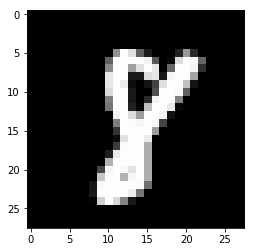

In [0]:
images, labels = next(iter(dataloader))

plt.imshow(images[0, 0], cmap='Greys_r')
plt.show()

In [0]:
class MaskedConv2d(nn.Conv2d):
	def __init__(self, mask_center, *args, **kwargs):
		super(MaskedConv2d, self).__init__(*args, **kwargs)
		self.register_buffer('mask', self.weight.data.clone())
		_, _, kH, kW = self.weight.size()
		self.mask.fill_(1)
		self.mask[:, :, kH // 2, kW // 2 + (mask_center == False):] = 0
		self.mask[:, :, kH // 2 + 1:] = 0

	def forward(self, x):
		self.weight.data *= self.mask
		return super(MaskedConv2d, self).forward(x)

class Upsample2D(nn.Module):
    def __init__(self, scale_factor, mode='nearest'):
        super(Upsample2D, self).__init__()
        self.interp = nn.functional.interpolate
        self.scale_factor = scale_factor
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale_factor, mode=self.mode)
        return x
    
class ResidualMaskedConv2d(nn.Module):
	def __init__(self, hidden_size, kernel_size=3):
		super(ResidualMaskedConv2d, self).__init__()
		
		self.residual = nn.Sequential(
            MaskedConv2d(False, hidden_size, hidden_size//2, kernel_size=1, bias=False), 
			nn.BatchNorm2d(hidden_size//2),
			nn.ReLU(inplace=True),
			MaskedConv2d(False, hidden_size//2, hidden_size//2, kernel_size=kernel_size, padding=kernel_size//2, bias=False), 
			nn.BatchNorm2d(hidden_size//2), 
			nn.ReLU(inplace=True),
			MaskedConv2d(False, hidden_size//2, hidden_size, kernel_size=1, bias=False), 
			nn.BatchNorm2d(hidden_size),
		)	

	def forward(self, x):
		return x + self.residual(x)

class PixelCNN(nn.Module):
    def __init__(self, num_classes, hidden_size=64):
        super(PixelCNN, self).__init__()
        
        self.initial = nn.Sequential(
            MaskedConv2d(True, 1, hidden_size, kernel_size=7, padding=3, bias=False), 
            nn.BatchNorm2d(hidden_size), 
            nn.ReLU(inplace=True)  
        )
        
        self.class_embedding = nn.Embedding(num_classes, hidden_size)
        
        self.cnn = nn.Sequential(          
            MaskedConv2d(False, hidden_size, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),
            MaskedConv2d(False, hidden_size, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),          
            MaskedConv2d(False, hidden_size, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),          
            ResidualMaskedConv2d(hidden_size),
            ResidualMaskedConv2d(hidden_size),
            ResidualMaskedConv2d(hidden_size),
            MaskedConv2d(False, hidden_size, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),
            MaskedConv2d(False, hidden_size, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),
            MaskedConv2d(False, hidden_size, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),
            
            nn.Conv2d(hidden_size, 256, kernel_size=1),
        )
        
    def forward(self, x, y=None):
        x = self.initial(x)
        if y is not None:
            y = self.class_embedding(y).unsqueeze(-1).unsqueeze(-1).expand(x.shape)
            x = x + y
        x = self.cnn(x)
        return x

In [0]:
pixelCNN = PixelCNN(num_classes=10, hidden_size=32)
pixelCNN.cuda()

PixelCNN(
  (initial): Sequential(
    (0): MaskedConv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (class_embedding): Embedding(10, 32)
  (cnn): Sequential(
    (0): MaskedConv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaskedConv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaskedConv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ResidualMaskedConv2d(
      (residual): Sequential(
        (0): MaskedCo

In [0]:
# sample
def sample(num_samples = 5, temperature = 1, label=None):   
    sample = torch.zeros(num_samples, 1, 28, 28).cuda()
    if label is None:
        labels = torch.randint(0, 10, (num_samples,)).cuda()
    else:
        labels = torch.tensor([label]*num_samples).cuda()
    print(labels.tolist())
    
    pixelCNN.eval()
    with torch.no_grad():
        for i in range(28):
            for j in range(28):
                pred = pixelCNN(sample, labels)
                pred = (pred[:, :, i, j]/temperature).softmax(dim=-1)                
                sample[:, :, i, j] = torch.multinomial(pred, 1).float() / 255. 

    plt.imshow(torch.cat([s for s in sample], dim=-1)[0].cpu() * 2, cmap='Greys_r')
    plt.show()

In [0]:
epochs = 15
print_every = 500

optimizer = optim.Adam(pixelCNN.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss() # weight=torch.tensor([1.0]+([2.0]*255)).cuda())

for e in range(1, epochs+1):
    total_loss = 0
    pixelCNN.train()
    start_time = time.time()
    for batch, (images, labels) in enumerate(dataloader):
        images, labels = images.cuda(), labels.cuda()
        target = (images[:,0] * 255).long()
        
        pred = pixelCNN(images, labels)       
        loss = criterion(pred, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if (batch+1) % print_every == 0 or (batch+1) == len(dataloader):
            elapsed_time = time.time() - start_time
            start_time = time.time()
            print(f"Epoch {e} ({batch+1}/{len(dataloader)}) - loss {total_loss/(batch+1)} ({elapsed_time:.1f}s)")
    
    sample(num_samples = 5) # sample after every epoch
    # scheduler.step()

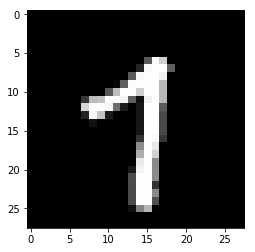

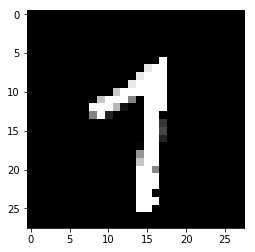

In [0]:
# check generation
images, labels = next(iter(dataloader))
pixelCNN.eval()
with torch.no_grad():
    pred = pixelCNN(images.cuda())
    pred = pred.softmax(-3).argmax(-3)

plt.imshow(images[0,0].cpu(), cmap='Greys_r')
plt.show()
plt.imshow(pred[0].cpu(), cmap='Greys_r')
plt.show()

[1, 7, 9, 5, 1]


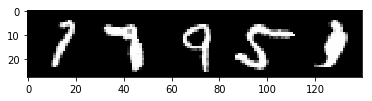

In [0]:
sample(num_samples = 5, temperature=1)

In [0]:
class PositionalEncoder(nn.Module):
    def __init__(self, embedding_size, max_seq_len):
        super(PositionalEncoder, self).__init__()
        self.embedding_size = embedding_size
        
        pos_encoder = torch.zeros(max_seq_len, embedding_size)
        for pos in range(max_seq_len):
            for i in range(0, embedding_size, 2):
                pos_encoder[pos, i] = math.sin(pos / (10000 ** ((2 * i)/embedding_size)))
                pos_encoder[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/embedding_size)))
                
        pos_encoder = pos_encoder.unsqueeze(0)
        self.register_buffer('pos_encoder', pos_encoder)
 
    def forward(self, x):
        x = x * math.sqrt(self.embedding_size)
        seq_len = x.size(1)
        x = x + self.pos_encoder[:, :seq_len]
        return x

In [0]:
class PixelTransformer(nn.Module):
    def __init__(self, hidden_size=64):
        super(PixelTransformer, self).__init__()
        
        max_size = 32
        heads = 2
        layers = 3
                
        # self.initial = nn.Sequential(
        #     MaskedConv2d(True, 1, hidden_size, kernel_size=7, padding=3, bias=False), 
        #     nn.BatchNorm2d(hidden_size), 
        #     nn.ReLU(inplace=True)  
        # )
        
        self.initial = nn.Sequential(
            nn.Conv2d(1, hidden_size, kernel_size=1), 
            nn.BatchNorm2d(hidden_size), 
            nn.ReLU(inplace=True)  
        )
        
        self.pos_encoder = PositionalEncoder(hidden_size, max_size*max_size)  
        
        encoder_layer = nn.TransformerEncoderLayer(hidden_size, nhead=heads, dim_feedforward=hidden_size, dropout=0.1)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=layers, norm=nn.LayerNorm(hidden_size))
        self.register_buffer('mask', nn.Transformer.generate_square_subsequent_mask(None, max_size*max_size))
        self.register_buffer('mask_initial', nn.Transformer.generate_square_subsequent_mask(None, max_size*max_size))
        for i in range(max_size):
            self.mask_initial.data[i, i] = -1e12 # if I use float('-inf') I get NANs eveywhere :/
            
        self.out = nn.Conv2d(hidden_size, 256, kernel_size=1)
        
        # for p in self.parameters():
        #     if p.dim() > 1:
        #         nn.init.xavier_uniform_(p)               
                    
    def forward(self, x):
        batch_size, _, width, height = x.shape
        x = self.initial(x) # N, C, W, H
        x = x.contiguous().view(x.size(0), x.size(1), -1).permute(0, 2, 1) # N, WxH, C  
        x = self.pos_encoder(x).permute(1, 0, 2) # WxH, N, C
        padding = x.new_zeros(1, x.size(1), x.size(2)) # torch.zeros(1, x.size(1), x.size(2)).to()
        x = torch.cat([padding, x], dim=0)[:-1] # move all values to the right and remove the last one
        x = self.transformer(x, self.mask[:x.size(0), :x.size(0)]) # WxH, N, C
        x = x.permute(1, 2, 0).contiguous().view(batch_size, -1, width, height) # N, C, W, H
        x = self.out(x)       
        return x

In [0]:
pixelTransformer = PixelTransformer(64)
pixelTransformer.cuda()

PixelTransformer(
  (initial): Sequential(
    (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pos_encoder): PositionalEncoder()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
    

In [0]:
# sample
def sample(num_samples = 5, temperature = 1):   
    sample = torch.zeros(num_samples, 1, 28, 28).cuda()
    
    pixelTransformer.eval()
    with torch.no_grad():
        for i in range(28):
            for j in range(28):
                pred = pixelTransformer(sample)
                pred = (pred[:, :, i, j]/temperature).softmax(dim=-1)                
                sample[:, :, i, j] = torch.multinomial(pred, 1).float() / 255. 

    plt.imshow(torch.cat([s for s in sample], dim=-1)[0].cpu() * 2, cmap='Greys_r')
    plt.show()

Epoch 1 (500/3750) - loss 1.1530859614610671 (53.6s)
Epoch 1 (1000/3750) - loss 1.098652745604515 (53.3s)
Epoch 1 (1500/3750) - loss 1.0761110455195109 (53.3s)
Epoch 1 (2000/3750) - loss 1.061862596511841 (53.3s)
Epoch 1 (2500/3750) - loss 1.049935702419281 (53.3s)
Epoch 1 (3000/3750) - loss 1.0397485436995824 (53.3s)
Epoch 1 (3500/3750) - loss 1.0317406477928162 (53.4s)
Epoch 1 (3750/3750) - loss 1.0281396951357524 (26.7s)


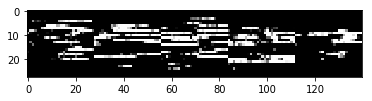

Epoch 2 (500/3750) - loss 0.970831935763359 (53.5s)
Epoch 2 (1000/3750) - loss 0.9697321400642395 (53.4s)
Epoch 2 (1500/3750) - loss 0.9670580703814824 (53.4s)
Epoch 2 (2000/3750) - loss 0.9634928153455258 (53.4s)
Epoch 2 (2500/3750) - loss 0.9595802304506302 (53.4s)
Epoch 2 (3000/3750) - loss 0.9559823804299037 (53.4s)
Epoch 2 (3500/3750) - loss 0.952635505097253 (53.5s)
Epoch 2 (3750/3750) - loss 0.9505845981915791 (26.7s)


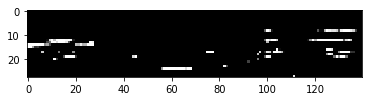

Epoch 3 (500/3750) - loss 0.9224510354995727 (53.4s)
Epoch 3 (1000/3750) - loss 0.9182057192921639 (53.4s)
Epoch 3 (1500/3750) - loss 0.9163773612976074 (53.4s)
Epoch 3 (2000/3750) - loss 0.9142747296392918 (53.4s)
Epoch 3 (2500/3750) - loss 0.9125244884490967 (53.4s)
Epoch 3 (3000/3750) - loss 0.911483449836572 (53.4s)
Epoch 3 (3500/3750) - loss 0.9086477595397404 (53.4s)
Epoch 3 (3750/3750) - loss 0.907422270043691 (26.7s)


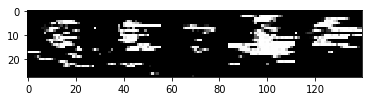

Epoch 4 (500/3750) - loss 0.8928868080377579 (53.3s)
Epoch 4 (1000/3750) - loss 0.8898452474474907 (53.5s)


In [0]:
epochs = 15
print_every = 500

optimizer = optim.Adam(pixelTransformer.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss() # weight=torch.tensor([1.0]+([2.0]*255)).cuda())

for e in range(1, epochs+1):
    total_loss = 0
    pixelTransformer.train()
    start_time = time.time()
    for batch, (images, labels) in enumerate(dataloader):
        images = images.cuda()
        target = (images[:,0] * 255).long()
        
        pred = pixelTransformer(images) 
        loss = criterion(pred, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if (batch+1) % print_every == 0 or (batch+1) == len(dataloader):
            elapsed_time = time.time() - start_time
            start_time = time.time()
            print(f"Epoch {e} ({batch+1}/{len(dataloader)}) - loss {total_loss/(batch+1)} ({elapsed_time:.1f}s)")
    
    sample(num_samples = 5) # sample after every epoch
    # scheduler.step()

In [0]:
# check generation
images, labels = next(iter(dataloader))
pixelCNN.eval()
with torch.no_grad():
    pred = pixelTransformer(images.cuda())
    pred = pred.softmax(-3).argmax(-3)

plt.imshow(images[0,0].cpu(), cmap='Greys_r')
plt.show()
plt.imshow(pred[0].cpu(), cmap='Greys_r')
plt.show()

In [0]:
sample(num_samples = 5)

In [0]:
# let's try with RGB image recolorizartion conditioning
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(56),
    torchvision.transforms.Lambda(lambda x: x.convert('YCbCr')),
    torchvision.transforms.ToTensor()
])
cifar = torchvision.datasets.CIFAR10('data', train=True, transform=transform, download=True)
sampler = SubsetRandomSampler(range(5000))
dataloader = DataLoader(cifar, batch_size=32, sampler=sampler)

sampler_test = SubsetRandomSampler(range(5000, 6000))
dataloader_test = DataLoader(cifar, batch_size=32, sampler=sampler_test)

0it [00:00, ?it/s]

170500096it [00:02, 70332172.88it/s]                               


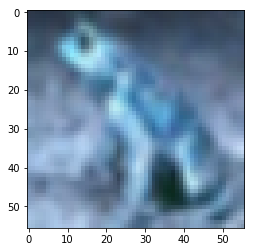

In [0]:
images, _ = next(iter(dataloader))
images.shape

image = cv2.cvtColor(images[0].permute(1, 2, 0).numpy(), cv2.COLOR_YCrCb2RGB) 

plt.imshow(image)
plt.show()

In [0]:
class RecolorPixelCNN(nn.Module):
    def __init__(self, hidden_size=64):
        super(RecolorPixelCNN, self).__init__()
        
        self.first = nn.Sequential(
            MaskedConv2d(True, 2*256, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),
        )
                
        self.cnn = nn.Sequential(  
            MaskedConv2d(False, hidden_size + 256, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),
            MaskedConv2d(False, hidden_size, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),          
            MaskedConv2d(False, hidden_size, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),          
            
            ResidualMaskedConv2d(hidden_size),
            ResidualMaskedConv2d(hidden_size),
            ResidualMaskedConv2d(hidden_size),
            
            MaskedConv2d(False, hidden_size, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),
            MaskedConv2d(False, hidden_size, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),
            MaskedConv2d(False, hidden_size, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),
            
            nn.Conv2d(hidden_size, 256 * 2, kernel_size=1),
        )
        
    def forward(self, x, conditioner):
        x = self.first(x)
        x = torch.cat((x, conditioner), dim=1)
        x = self.cnn(x)
        x = x.view(-1, 2, 256, 56, 56).permute(0, 2, 3, 4, 1)
        return x

In [0]:
recolorPixelCNN = RecolorPixelCNN(64)
recolorPixelCNN.cuda()

RecolorPixelCNN(
  (first): Sequential(
    (0): MaskedConv2d(512, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (cnn): Sequential(
    (0): MaskedConv2d(320, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ResidualMaskedConv2d(
      (residual): Sequential(
        (0): MaskedConv2d(64, 32, kernel_size=(1, 1)

In [0]:
test = torch.randn(1, 2*256, 56, 56).cuda()
cond = torch.randn(1, 256, 56, 56).cuda()
with torch.no_grad():
    pred = recolorPixelCNN(test, cond)
    
pred.shape

torch.Size([1, 256, 56, 56, 2])

In [0]:
def sample(images, temperature = 1):   
    recolorPixelCNN.eval()
    sample = torch.zeros(len(images), 2, 56, 56).cuda()
    conditioner = nn.functional.one_hot((images[:,0] * 255).long(), 256).permute(0, 3, 1, 2).float()
    
    with torch.no_grad():
        for i in range(56):
            for j in range(56):
                sources = nn.functional.one_hot((sample * 255).long(), 256).permute(0, 2, 3, 1, 4).contiguous().view(-1, 56, 56, 256*2).permute(0, 3, 1, 2).float()
                pred = recolorPixelCNN(sources, conditioner)
                pred = pred[:, :, i, j]
                for k in range(2):
                    pixel = (pred[:,:,k]/temperature).softmax(dim=-1)                    
                    pixel = torch.multinomial(pixel, 1).float() / 255. 
                    sample[:, k, i, j] = pixel.squeeze(-1)
    
    # pred = recolorPixelCNN(sources)
    # for k in range(2):
    #     pixels = (pred[:,:,:,:,k]/temperature).softmax(dim=1)
    #     pixels = pixels.permute(0, 2, 3, 1).contiguous().view(-1, 256)      
    #     pixels = torch.multinomial(pixels, 1).float() / 255.
    #     pixels = pixels.view(-1, 56, 56)
    #     sample[:, k] = pixels
    
    reconstructed = torch.cat([images[:, 0:1], sample], dim=1)
    
    def color_restore(image):
        image = image.permute(1, 2, 0).cpu().numpy()
        image = cv2.cvtColor(image, cv2.COLOR_YCrCb2RGB) 
        return (image - (np.amin(image, (0, 1)))) / (np.amax(image, (0, 1)) - np.amin(image, (0, 1)))
       
    original = np.hstack([color_restore(img) for img in images])
    reconstructed = np.hstack([color_restore(img) for img in reconstructed])
    
    reconstructed = np.vstack([original, reconstructed])
     
    plt.imshow(reconstructed)
    plt.show()

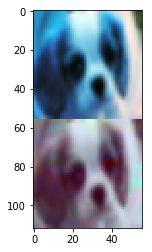

In [0]:
images, _ = next(iter(dataloader))
sample(images[:1].cuda())

Epoch 1 (100/157) - loss 1.1899105250835418 (41.2s)
Epoch 1 (157/157) - loss 1.1763731256412093 (23.2s)
Epoch 2 (100/157) - loss 1.1580596494674682 (41.1s)
Epoch 2 (157/157) - loss 1.1564280432500658 (23.3s)
Epoch 3 (100/157) - loss 1.1479631227254867 (41.0s)
Epoch 3 (157/157) - loss 1.1467086687968795 (23.2s)
Epoch 4 (100/157) - loss 1.1329933869838715 (41.1s)
Epoch 4 (157/157) - loss 1.1332884890258692 (23.2s)
Epoch 5 (100/157) - loss 1.138454456925392 (41.1s)
Epoch 5 (157/157) - loss 1.132440609157465 (23.2s)
Epoch 6 (100/157) - loss 1.1086264938116073 (41.1s)
Epoch 6 (157/157) - loss 1.107187850080478 (23.2s)
Epoch 7 (100/157) - loss 1.0923417860269546 (41.1s)
Epoch 7 (157/157) - loss 1.1099044244000866 (23.2s)
Epoch 8 (100/157) - loss 1.135738582611084 (41.1s)
Epoch 8 (157/157) - loss 1.1235686274850445 (23.2s)
Epoch 9 (100/157) - loss 1.0938836818933486 (41.1s)
Epoch 9 (157/157) - loss 1.0910500155133047 (23.2s)
Epoch 10 (100/157) - loss 1.078293035030365 (41.1s)
Epoch 10 (157/15

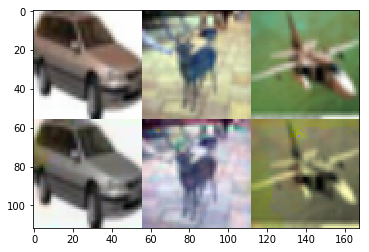

In [0]:
epochs = 20
print_every = 100

optimizer = optim.Adam(recolorPixelCNN.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for e in range(1, epochs+1):
    total_loss = 0
    recolorPixelCNN.train()
    start_time = time.time()
    for batch, (images, labels) in enumerate(dataloader):
        images = images.cuda()
        source = nn.functional.one_hot((images[:,1:] * 255).long(), 256).permute(0, 2, 3, 1, 4).contiguous().view(-1, 56, 56, 256*2).permute(0, 3, 1, 2).float()
        conditioner = nn.functional.one_hot((images[:,0] * 255).long(), 256).permute(0, 3, 1, 2).float()
        target = (images[:,1:] * 255).long().permute(0, 2, 3, 1)
        
        pred = recolorPixelCNN(source, conditioner)  
        loss = criterion(pred, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if (batch+1) % print_every == 0 or (batch+1) == len(dataloader):
            elapsed_time = time.time() - start_time
            start_time = time.time()
            print(f"Epoch {e} ({batch+1}/{len(dataloader)}) - loss {total_loss/(batch+1)} ({elapsed_time:.1f}s)")
    
sample(images[:3]) # sample at the end

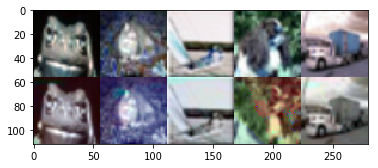

CPU times: user 3min 34s, sys: 3min 1s, total: 6min 35s
Wall time: 6min 35s


In [0]:
%%time

images, _ = next(iter(dataloader_test))
sample(images[:5].cuda())